In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error


In [3]:
from google.colab import files
uploaded = files.upload()


Saving train_FD002.txt to train_FD002.txt


In [9]:
import pandas as pd

# Define column names
column_names = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f's{i}' for i in range(1, 22)]

# Read the uploaded FD002 dataset
df = pd.read_csv('train_FD002.txt', sep=' ', header=None)

# Drop extra empty columns caused by multiple spaces
df.dropna(axis=1, inplace=True)

# Assign meaningful column names
df.columns = column_names

# Preview
df.head()


,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [10]:
rul = df.groupby('unit')['cycle'].max().reset_index()
rul.columns = ['unit', 'max_cycle']
df = df.merge(rul, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)


In [11]:
sensor_cols = df.columns[5:-1]  # exclude unit, cycle, op settings, RUL
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [12]:
def gen_sequence(id_df, seq_length, sensor_cols):
    data_array = id_df[sensor_cols].values
    sequences = []
    for start in range(len(data_array) - seq_length):
        seq = data_array[start:start + seq_length]
        sequences.append(seq)
    return np.array(sequences)

def gen_labels(id_df, seq_length, label='RUL'):
    label_array = id_df[label].values
    return label_array[seq_length:]


In [13]:
sequence_length = 50
X, y = [], []

for unit_id in df['unit'].unique():
    unit_df = df[df['unit'] == unit_id]
    seq = gen_sequence(unit_df, sequence_length, sensor_cols)
    label = gen_labels(unit_df, sequence_length)
    X.extend(seq)
    y.extend(label)

X = np.array(X)
y = np.array(y)


In [14]:
model = Sequential([
    LSTM(100, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,051 (308.79 KB)

 Trainable params: 79,051 (308.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X, y, epochs=20, batch_size=200, validation_split=0.1, verbose=2)


Epoch 1/20
184/184 - 56s - 303ms/step - loss: 8384.4512 - val_loss: 9876.2256
Epoch 2/20
184/184 - 80s - 433ms/step - loss: 6996.3657 - val_loss: 8595.3555
Epoch 3/20
184/184 - 80s - 433ms/step - loss: 6025.8604 - val_loss: 7573.6221
Epoch 4/20
184/184 - 84s - 454ms/step - loss: 5259.8555 - val_loss: 6756.2422
Epoch 5/20
184/184 - 80s - 435ms/step - loss: 4671.5791 - val_loss: 6107.3149
Epoch 6/20
184/184 - 83s - 450ms/step - loss: 4226.6914 - val_loss: 5601.0991
Epoch 7/20
184/184 - 47s - 254ms/step - loss: 3901.9148 - val_loss: 5211.2915
Epoch 8/20
184/184 - 83s - 448ms/step - loss: 3658.1160 - val_loss: 4917.9844
Epoch 9/20
184/184 - 53s - 287ms/step - loss: 3502.6470 - val_loss: 4703.1284
Epoch 10/20
184/184 - 77s - 419ms/step - loss: 3394.6921 - val_loss: 4546.8169
Epoch 11/20
184/184 - 84s - 456ms/step - loss: 3321.4189 - val_loss: 4435.4634
Epoch 12/20
184/184 - 52s - 283ms/step - loss: 3275.8022 - val_loss: 4357.6982
Epoch 13/20
184/184 - 78s - 425ms/step - loss: 3257.1086 - va

1274/1274 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step
RMSE: 57.48


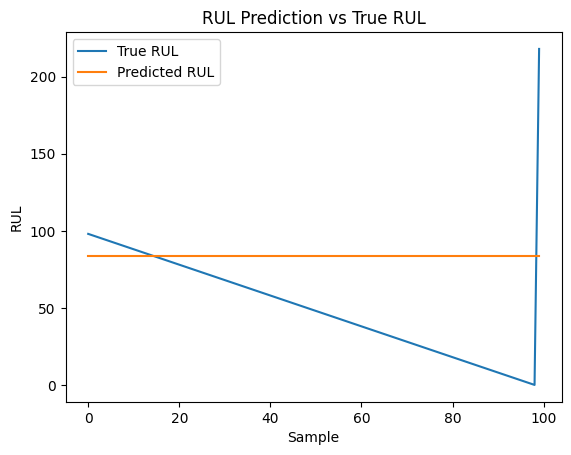

In [16]:
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE: {rmse:.2f}')

plt.plot(y[:100], label='True RUL')
plt.plot(y_pred[:100], label='Predicted RUL')
plt.legend()
plt.title("RUL Prediction vs True RUL")
plt.xlabel("Sample")
plt.ylabel("RUL")
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


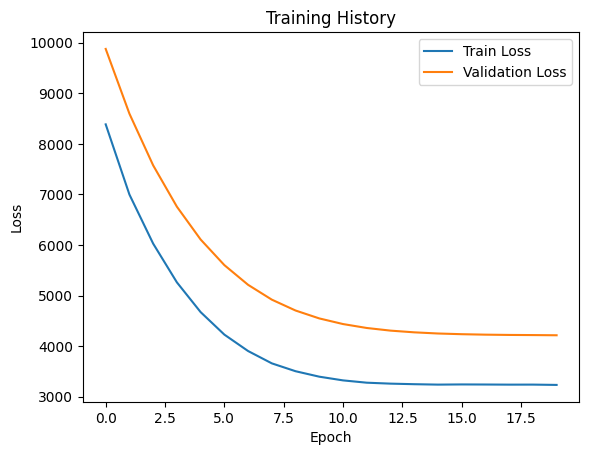

In [18]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()


255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


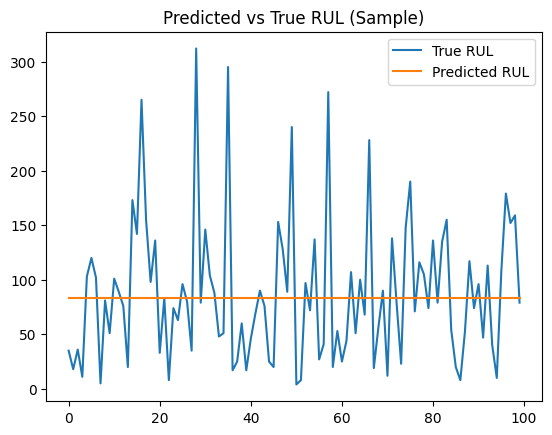

In [19]:
y_pred = model.predict(X_test)

plt.plot(y_test[:100], label='True RUL')
plt.plot(y_pred[:100], label='Predicted RUL')
plt.legend()
plt.title("Predicted vs True RUL (Sample)")
plt.show()


In [20]:
model.save("fd002_rul_model.h5")


In [21]:
from keras.models import load_model
model = load_model("fd002_rul_model.h5")
